# Описание

Создание визуализации-коллажа работы классификатора по отдельным сюжетам

## Зависимости

In [4]:
# %load ./src/imports/basic_imports.py
import os
import pandas as pd
import numpy as np


In [5]:
# %load ./src/imports/tqdm_imports.py

! pip install ftfy regex tqdm
from tqdm import tqdm
tqdm.pandas()


Defaulting to user installation because normal site-packages is not writeable


In [6]:
# %load ./src/imports/multiprocessing_imports.py

from multiprocessing import Pool


In [7]:
# %load ./src/imports/PIL_imports.py

! pip install pillow

from PIL import Image, ImageFilter, ImageDraw, ImageFont


Defaulting to user installation because normal site-packages is not writeable


In [8]:
# %load ./src/imports/random_imports.py

from random import sample, randint


## Параметры

In [9]:
# определяем колонку по которой будем связывать все таблицы
global_key = 'regNumber'
# путь к папке к изображениями из ГК
img_data_url = './data/img_for_clasifire/V__270523/'

In [10]:
# результаты класификации и кластеризации
url_dict = {
    'DBSCAN_clear':'./out/classif_img_out/DBSCAN_clear__classif_1694.csv',
    'KMeans_clear_best': './out/classif_img_out/KMeans_clear_best_classif_210.csv',
    'df_text_classter':'./out/classif_text_out/plotted19_06_2.csv'
    }

## Вспомогательные функции

In [27]:
# %load ./src/functions/csv2DF.py

# загрузка файлов по словарю
# name - имя
# link_dir - словарь
# sep = "," - разделитель
def csv2DF(name, link_dir = url_dict, sep = ","):
    url = link_dir[name]
    df = pd.read_csv(url, encoding = 'utf8', sep = sep )
    return df


In [12]:
# %load ./src/functions/to_pool.py

# для многоканальной обработки списка любой функцией

# item_list - список элементов
# method - функция-обработчик
def to_pool(item_list, method):
    with Pool(processes=os.cpu_count()) as pool:
         rezult_list = []
         for res in tqdm(pool.imap(method, (i for i in item_list)),
                     total = len(item_list)):
             rezult_list.append(res)
    return rezult_list

def to_tqdm(item_list, method):
  rezult_list = []
  for res in tqdm(map(method, (i for i in item_list)),
                     total = len(item_list)):
             rezult_list.append(res)
  return rezult_list


In [13]:
# %load ./src/functions/downloadFromDriverCSV.py

# скачать с гугл-диска таблицу в формате csv
# возвращает таблицу

# url - ссылка доступа, полученная с гугл-диска
def downloadFromDriverCSV(url, sep=','):
   file_id=url.split('/')[-2]
   dwn_url='https://drive.google.com/uc?id=' + file_id
   df = pd.read_csv(dwn_url, encoding = 'utf8', sep = sep)

   return df


In [14]:
# %load ./src/functions/get_file_list.py

# считать список файлов из всех поддерикторий
# возвращает список имен файлов и уникальные расширения файлов

# path - путь к директории type - str
# name_list - список названий файлов по которому фильтруем type - list
def get_file_list(path, name_list = []):
    rezult = []
    variant = set()
    for root, dirs, files in os.walk(path, topdown = False):        
        for name in files:
            if len(name_list) > 0:
               if not(filter_fille_name(name, name_list)):
                  continue
            
            rezult.append(os.path.join(root, name))
            # если нет расширений у файлов добавляем None, иначе - название расширения
            file_extension = name.split('.')[1] if len(name.split('.')) > 1 else None
            variant.add(file_extension) 
    return rezult, variant


In [15]:
# %load ./src/functions/file2PIL.py

# конвертация в формат cv2
# возвращает словарь вида {'img':вектор изображения в формате PIL,'title':название}

# filename - полный путь к файлу

def file2PIL(filename):  
     return {'img': Image.open(filename), 'title':filename}


In [16]:
# %load ./src/functions/csv2DF.py

# загрузка файлов по словарю
# name - имя
# link_dir - словарь
# sep = "," - разделитель
def csv2DF(name, link_dir = url_dict, sep = ","):
    url = link_dir[name]
    df = pd.read_csv(url)
    return df


## Загрузка изображений для визуализации

Для дальнейшей работы используются результаты выгрузки данных ГК.
Файлы изображений должны именоваться по следующему шаблону:
regNumber_postfics.jpg, где

regNumber - регестрационный номер в ГК, это id служит для связи между изображением и предметом
postfics - число 1, 2 или 3, где 1 - обозначает основное изображение в карточке объекта в ГК, 2, 3 - остальные

In [17]:
# %load ./src/functions/getImgId.py

# возвращает id объекта из пути к файлу картинки и преффикс 1 или 2

# fille_path - путь к файлу
def setImgId(fille_path):  
  fille_name = fille_path.split('/')[-1]
  return fille_name.split('.')[0].split('_')[0], fille_name.split('.')[0].split('_')[1]  

# возвращает id объекта из пути к файлу картинки
# fille_path - путь к файлу
def getImgId(fille_path):    
  return int(setImgId(fille_path)[0])

# возвращает преффикс 1 или 2 объекта из пути к файлу картинки

# fille_path - путь к файлу
def filterImgPreff(fille_path, pref_list = [1, '1']):  
    fille_pref = setImgId(fille_path)[1]
    return fille_pref in pref_list


In [18]:
# загрузка изображений 
# img_list - список изображений
# type_set - список расширений загруженных файлов для проверки результатов
img_list, type_set = get_file_list(img_data_url)
type_set

{'jpg'}

In [19]:
# переводим картинки из списка в формат PIL
image_list = to_pool(img_list, eval('file2PIL'))

100%|██████████████████████████████████████| 1733/1733 [00:15<00:00, 110.06it/s]


In [20]:
# чтобы не создавать путаницу, дажлим картинки с постфиксом, отличными от 1
image_list= list(filter(lambda item: filterImgPreff(item['title'], [1, '1']), image_list))
print(len(image_list))

1677


In [21]:
data_img =  pd.DataFrame(image_list)
# добавляем колонку с id по которому матчим таблицы
image_num_list = to_pool(data_img['title'].tolist(), eval('getImgId'))
data_img[global_key] = image_num_list

100%|████████████████████████████████████| 1677/1677 [00:00<00:00, 30407.70it/s]


In [22]:
data_img = data_img.drop(columns = ['title'])
data_img.head()

,img,regNumber
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,5607611
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,28869080
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17333401
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,5607629
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26157177


## Загрузка результатов классификации

In [29]:
df_DBSCAN_clear__classif_rezult = csv2DF('DBSCAN_clear')
df_KMeans_clear_best= csv2DF('KMeans_clear_best')

text_classif = csv2DF('df_text_classter', sep = ";")


## Функции коллажирования

In [30]:
# %load ./src/functions/PIL_collage.py

from PIL import ImageFilter, ImageDraw, ImageFont

# размеры картинок-миниатюр для вывода 
GLOBAL_thumb_size = (128, 128)
# положение картинки на миниатюре, если она не вписывается в квадрат 
GLOBAL_resize_type = 'center'

# количество картинок в ряду коллажа
GLOBAL_сollage_cols = 5
# фон картинок если не вписываются в превью, если не задан в качестве фона используем размытое изображени
GLOBAL_bg_color = (232, 232, 232, 0)

# путь к шрифту, используемому при добавлении надписи на изображение
GLOBAL_font_family = "./src/DinCyRg_.ttf"
# размер шрифта, по умолчанию при добавлении надписи на изображение
GLOBAL_font_size = 30
# цвет шрифта, по умолчанию при добавлении надписи на изображение
GLOBAL_font_color = (9, 9, 9, 255)

def get_text_dimensions(text_string, font):
    # https://stackoverflow.com/a/46220683/9263761
    ascent, descent = font.getmetrics()

    text_width = font.getmask(text_string).getbbox()[2]
    text_height = font.getmask(text_string).getbbox()[3] + descent

    return (text_width, text_height, ascent, descent)

def paste_text(
       img_source, img_text, 
       inner_size = (0,0),
       text_position = 'inner', 
       bg_color = GLOBAL_bg_color, 
       font_family = GLOBAL_font_family, 
       font_size=GLOBAL_font_size, 
       fill=GLOBAL_font_color, 
       align = 'left'):    
    
    font = ImageFont.truetype(font_family, font_size)
    text_width, text_height, text_ascent, text_descent = get_text_dimensions(str(img_text), font)
    
    if (text_position == 'inner_top') | (text_position == 'inner_bottom'):
       img = img_source.copy()      
       
       if text_position == 'inner_top':
           y = (img_source.size[1] // 2) - (inner_size[1]//2) - text_height - text_descent
       else:
           y = (img_source.size[1] // 2) + (inner_size[1]//2) + text_height
    
    else:
       # добавляем отсуп под текст          
       adding_size = text_height  + text_descent    
       img = Image.new('RGBA', (img_source.size[0], img_source.size[1] + adding_size), color = bg_color)    
       cord_w = 0               
       cord_h = adding_size if text_position == 'title' else 0           
       img.paste(img_source, box=(cord_w, cord_h))
       y = img_source.size[1] if text_position == 'bottom' else  0                 
    
    x = (img.size[0]-text_width)/2 if align== 'center' else 0    
    position = (x, y)
    
    draw = ImageDraw.Draw(img)    
    #draw.text(position, str(img_text), fill=fill, font=font, align=align)    
    draw.multiline_text(position, str(img_text), fill=fill, font=font, align=align)   
    
    return img

# преведение картинок к заданному размеру для удобства коллажирования

# img - картинка формата PIL
# size = GLOBAL_thumb_size - размер к которому приводим картинки
# bg_color = GLOBAL_bg_color - цвет фона блока если изображение не вписываются в превью, если не задан в качестве фона используем размытое изображени
def resize_img(
    img_source, 
    size = GLOBAL_thumb_size, 
    resize_type = GLOBAL_resize_type, 
    bg_color = GLOBAL_bg_color, 
    border = 0,
    img_text_list = []
    ):  
    
    img = img_source.copy()
    thumbnail_size = (size[0] - 2*border, size[1] - 2*border)
    
    img.thumbnail(thumbnail_size)    
    current_size = img.size
    # если картинка не вписывается в квадрат, создаем фон из размытого изображения / или заданного цвета
    if (current_size[0] < thumbnail_size[0]) | (current_size[1] < thumbnail_size[1]):
       if bg_color:
          new_img = Image.new('RGBA', size, color = bg_color)
       else:
          new_img = img.filter(filter=ImageFilter.GaussianBlur)              
          new_img = new_img.resize(thumbnail_size)  
       
       if resize_type == 'center': #вставляем по центру квадрата
          cord_w = (size[0]//2) - current_size[0]//2
          cord_h = (size[1]//2) - current_size[1]//2  
       else:
          cord_w = (size[0]//2) - current_size[0]//2
          cord_h = border
       new_img.paste(img, box=(cord_w, cord_h))    
    
       # если есть текст - вставляем
       if len(img_text_list) != 0:
          for row in img_text_list:
              img_text = row['text']
              font_size  = row['font_size']
              text_align  = row['text_align']
              text_position = row['text_position']
                
              new_img = paste_text(new_img, img_text, inner_size = current_size, text_position = text_position, font_size=font_size, align = text_align)
       return new_img

    return img

# находим суммарную/максимальную высоту всех картинок в листе
def get_total_h(img_list, return_max = False):    
    rezult_list = []
    for img in img_list:
        rezult_list.append(img.size[1])
    if return_max:
        rezult = max(rezult_list)
    else:
        rezult = sum(rezult_list)
    return rezult

# складываем картинки по высоте
def set_full_img(img_list, total_w, bg_color = GLOBAL_bg_color):
    total_h = get_total_h(img_list)
    new_img = Image.new('RGBA', (total_w, total_h), color = bg_color)
    y = 0
    for img in img_list:
        new_img.paste(img, (0, y))
        y += img.size[1]
        
    return new_img

# создание коллажа
def create_collage(img_list, cols = GLOBAL_сollage_cols, size = GLOBAL_thumb_size):
    thumb_width = size[0]
    thumb_height = size[1]
    # если список пустой - создаем пустую картинку заданной ширины
    if len(img_list) == 0:
       width = cols*thumb_width
       height = thumb_height

       new_img = Image.new('RGBA', (width, height))

       return new_img

    # определяем высоту и ширину коллажа    
    # чтобы не подключать math ради одного округления вверх такая странная конструкция
    rows = len(img_list) // cols if (len(img_list) // cols) == (len(img_list) / cols) else (len(img_list) // cols) + 1
    
    width = cols*thumb_width
    height = rows*thumb_height
    
    new_img = Image.new('RGBA', (width, height))
        
    i, x, y = 0, 0, 0
    for row in range(rows):        
            if i == len(img_list):
              break
            for col in range(cols):
                if i == len(img_list):
                  break                    
                new_img.paste(img_list[i], (x, y))
                i += 1
                x += thumb_width
            y += thumb_height
            x = 0

    return new_img

# конвертируем для коллажа cv2 в PIL
def cv2PIL(opencv_image):
    color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)  
    return Image.fromarray(color_coverted)

# уменьшаем и выводим
def makeCollage(list_img_to_collage, cols = GLOBAL_сollage_cols, cv2_img = False):
    if cv2_img:
       list_img_to_collage = to_pool(list_img_to_collage, eval('cv2PIL'))
    images_small = to_pool(list_img_to_collage, eval('resize_img'))
    images_collage = create_collage(images_small, cols = cols)
    
    return images_collage

# уменьшаем и выводим с заданными параметрами
def makeCollage_size(list_img_to_collage, cols = GLOBAL_сollage_cols, size = GLOBAL_thumb_size, bg_color = GLOBAL_bg_color, cv2_img = False):
    if cv2_img:
       list_img_to_collage = to_pool(list_img_to_collage, eval('cv2PIL'))
    images_small = [resize_img(item, size = size, bg_color = bg_color) for item in list_img_to_collage]
    images_collage = create_collage(images_small, cols = cols, size = size)
    
    return images_collage



In [34]:
# %load ./src/functions/print_collage_for_clasters.py

# словарь для расшифровки уровней опосредованностей
GLOBAL_tree_dict = {
    0:'Не имеет отношение к Махаеву',
    1:'Авторский оригинал',
    2:'По оригиналу Махаева',
    3:'По гравюре с оригинала',
    4:'Массовая продукция',
    5:'Копия копии'
}

# печатаем только по сюжетам
# df - датафрейм результатов для печати вида:
#     колонка id, связывающая с пулом изображений (по умолчанию 'regNumber'),
#     поле с номером сюжета (по умолчанию 'labels'), 
# img_df = data_img - дата изображений для визуализации
# thumb_size=GLOBAL_thumb_size - размер миниатюр каждого изображения в итоговом коллаже
# cols = GLOBAL_сollage_cols - количество колонок в коллаже
# col_key = 'labels' - id поля с номером сюжета
def print_labels(df, 
                 img_df = data_img, 
                 thumb_size=GLOBAL_thumb_size,                            
                 cols = GLOBAL_сollage_cols,
                 col_key = 'labels'
                 ):
    labels_list = np.unique(df[col_key])

    full_img_w = thumb_size[0]*cols

    collage_list = []

    for i in labels_list:
        plot_title = 'Сюжет №' + str(i)
        collage_list_plot = []
        
        # берем все id сюжета = i
        key_list = df[(df[col_key] == i)][global_key].tolist()
        if len(key_list) == 0:
           continue        

        img_list_temp = img_df[img_df[global_key].isin(key_list)].copy().to_dict(orient='records')        
        
        for item in img_list_temp:
            text_list = [{'text': item[global_key], 'font_size': 12,'text_align': 'center','text_position':'inner_bottom'}]
            if printTrueConnect:
                    connect_key = df[df[global_key] == item[global_key]][col_connect].tolist()[0]                    
                    true_connect = GLOBAL_tree_dict[connect_key]
                    
                    text_list.append({'text': true_connect,'font_size': 12,'text_align': 'center','text_position':'inner_top'})
            img = resize_img(item['img'], size = thumb_size, border = 24, img_text_list = text_list)
            collage_list_plot.append(img)  
            
        max_img_h = max(thumb_size[1], get_total_h(collage_list_plot, return_max = True))        
        plot_img =  create_collage(collage_list_plot, cols = cols, size = (thumb_size[0], max_img_h))
        plot_img = paste_text(plot_img, plot_title, text_position = 'title')
        collage_list.append(plot_img)

    full_img = set_full_img(collage_list, full_img_w) 
    return full_img

# печатаем по классам + уровням опосредованности
# df - датафрейм результатов для печати вида:
#      колонка id, связывающая с пулом изображений (по умолчанию 'regNumber'),
#      поле с номером сюжета (по умолчанию 'labels'),
#      колонка с номером предсказанного уровня опосредовательности (по умолчанию 'class_predict')
#      при необходимости печати реального уровня колонка с номером реального уровня опосредовательности (по умолчанию 'connectedness')
# img_df = data_img - дата изображений для визуализации
# thumb_size=GLOBAL_thumb_size - размер миниатюр каждого изображения в итоговом коллаже
# cols = GLOBAL_сollage_cols - количество колонок в коллаже
# col_key = 'class_predict'- id поля с номером уровня
# col_plot = 'labels' - id поля с номером сюжета
# printTrueConnect = False, - дополнять изображение реальным уровнем опосредовательности
# col_connect = 'connectedness' - id поля с номером реального уровня опосредовательности 
def print_labels_classif(df, 
                          img_df = data_img, 
                          thumb_size=GLOBAL_thumb_size,                            
                          cols = GLOBAL_сollage_cols,
                          col_key = 'class_predict',
                          col_plot = 'labels',
                          printTrueConnect = False,
                          col_connect = 'connectedness'
                         ):
    labels_list = np.unique(df[col_plot])
    level_list = np.unique(df[col_key])

    full_img_w = thumb_size[0]*cols

    collage_list = []

    for i in labels_list:
        plot_title = 'Сюжет №' + str(i)
        collage_list_plot = []

        for j in level_list:        
            level_title = GLOBAL_tree_dict[j]

            # берем все id сюжета = i и уровня опосредовательности = j
            key_list = df[(df[col_plot] == i) & (df[col_key] == j)][global_key].tolist()
            if len(key_list) == 0:
                continue        

            img_list_temp = img_df[img_df[global_key].isin(key_list)].copy().to_dict(orient='records')        
            collage_list_level = []
            for item in img_list_temp:  
                text_list = [{'text': item[global_key], 'font_size': 12,'text_align': 'center','text_position':'inner_bottom'}]
                if printTrueConnect:
                    connect_key = df[df[global_key] == item[global_key]][col_connect].tolist()[0]                    
                    true_connect = GLOBAL_tree_dict[connect_key]
                    
                    text_list.append({'text': true_connect,'font_size': 12,'text_align': 'center','text_position':'inner_top'})
                img = resize_img(item['img'], size = thumb_size, border = 24, img_text_list = text_list)                  
                collage_list_level.append(img)  

            max_img_h = max(thumb_size[1], get_total_h(collage_list_level, return_max = True))        
            level_img = create_collage(collage_list_level, cols = cols, size = (thumb_size[0], max_img_h))                
            level_img = paste_text(level_img, level_title, font_size=24, text_position = 'title')

            collage_list_plot.append(level_img)    

        plot_img = set_full_img(collage_list_plot, full_img_w)
        plot_img = paste_text(plot_img, plot_title, text_position = 'title')
        collage_list.append(plot_img)

    full_img = set_full_img(collage_list, full_img_w) 
    return full_img


# создает произвольный коллаж из переданных параметров без разделения по уровням

# df - дата фрейм связанный с img_df ключом
# img_df - дата фрейм с колонками 'img' - типа PIC/CV2, 'title' - имя картинки = ссылка на картинку в выгрузке 
# sampel_size = 300, size = GLOBAL_thumb_size, cols = GLOBAL_сollage_cols, cv2_img = False - параметры печати

def printVizualCollag_univers(df, img_df = data_img, sampel_size = 300, size = GLOBAL_thumb_size, cols = GLOBAL_сollage_cols, cv2_img = False):
    list_temp = df[global_key].tolist()
    rezult_list = img_df[img_df[global_key].isin(list_temp)]['img'].tolist()  
   
    if len(rezult_list) > sampel_size:
       rezult_list = sample(rezult_list, sampel_size)
    
    return makeCollage_size(rezult_list, size = size, cols = cols, cv2_img = cv2_img)


## Вывод результата

Печатаем все изображения внутри выбранного сюжета или списка сюжетов

#### По текстам

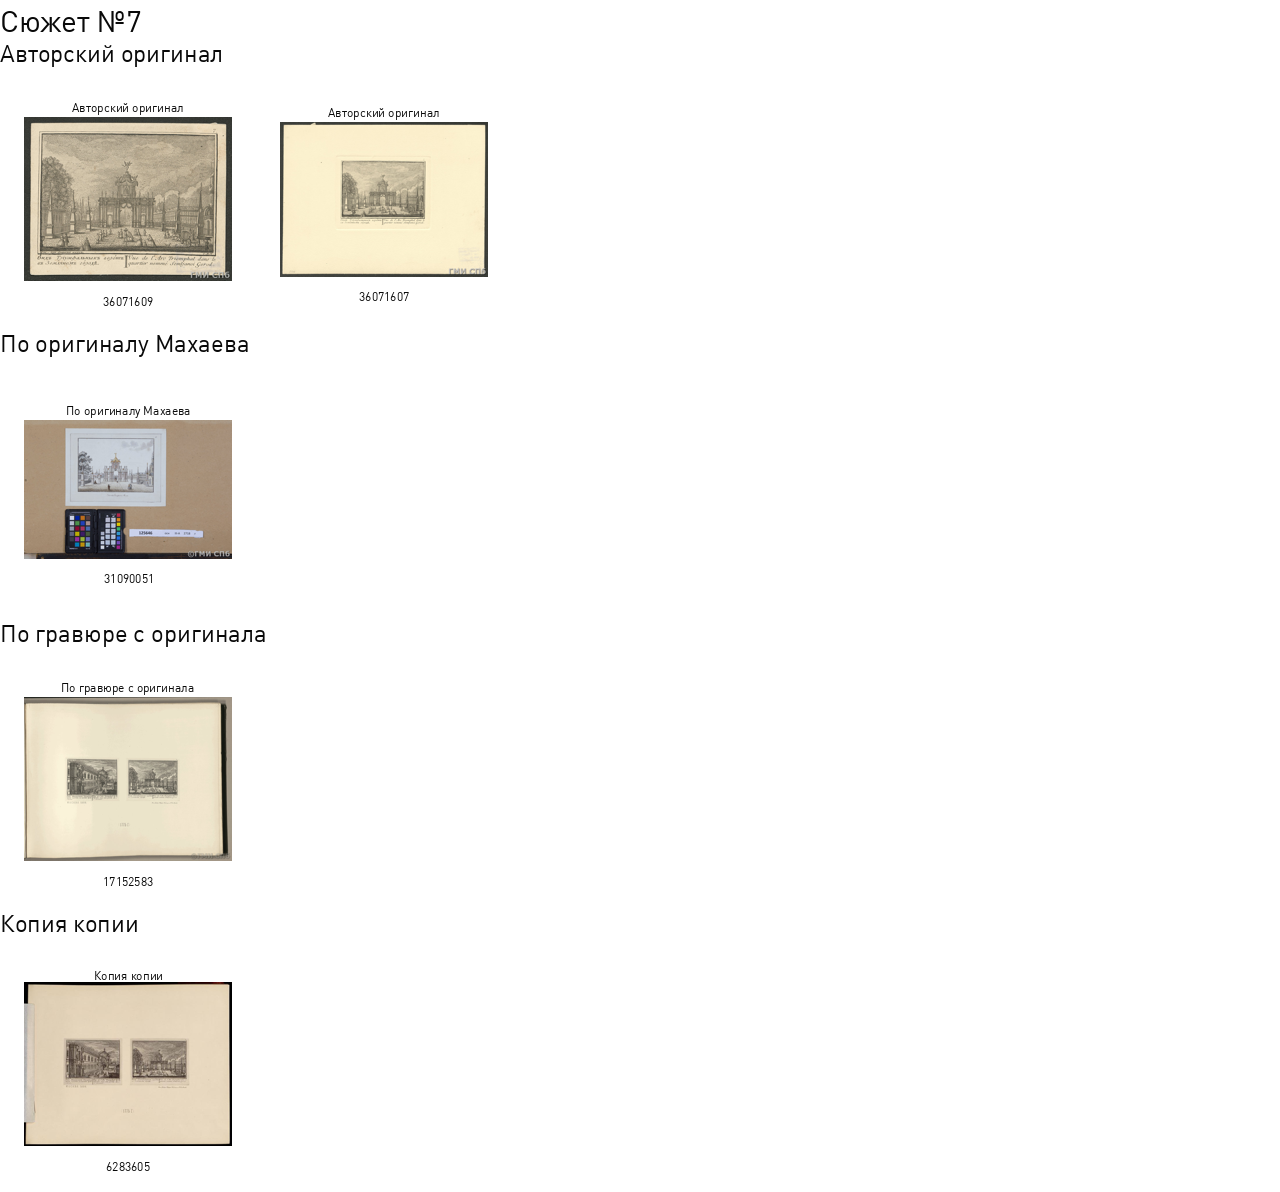

In [35]:
#[7,80,85,16,55]
df_temp = text_classif[text_classif['pred_plot'].isin([7])].copy()
print_labels_classif(df_temp, 
                          img_df = data_img, 
                          thumb_size=(256, 256),                            
                          cols = 5,
                          col_key = 'pred_connectedness',
                          col_plot = 'pred_plot',
                          printTrueConnect = True
                         )

#### По изображениям

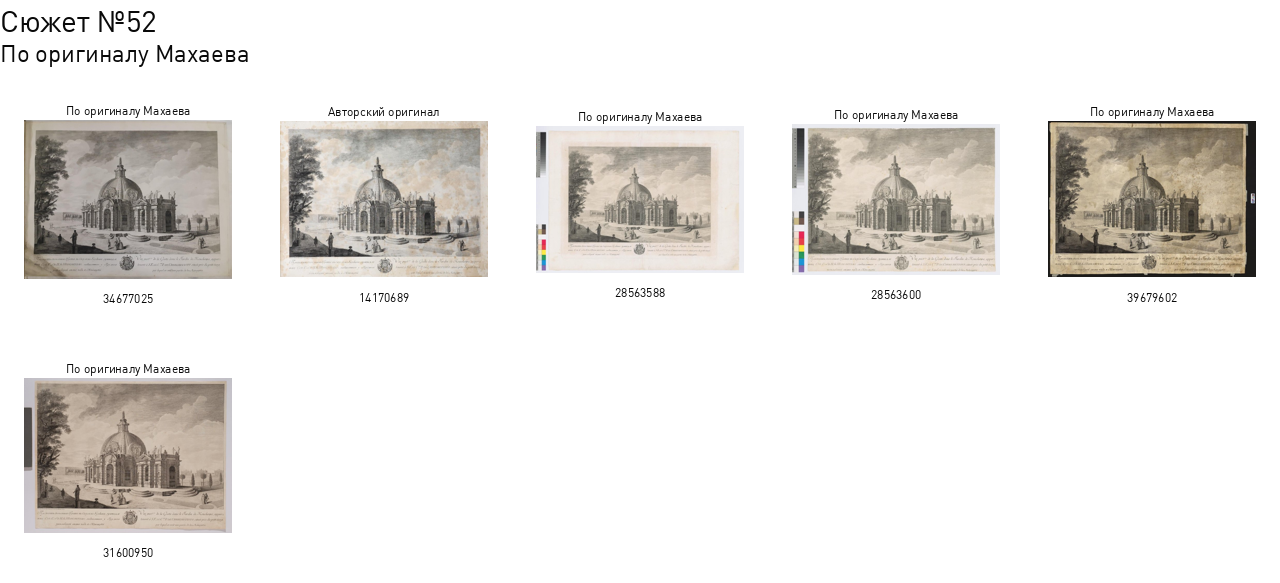

In [36]:
df_temp = df_DBSCAN_clear__classif_rezult[df_DBSCAN_clear__classif_rezult['labels'].isin([52])].copy()
print_labels_classif(df_temp,  
                     img_df = data_img, 
                     thumb_size=(256,256),
                     cols = 5,
                     col_key = 'class_predict',
                     printTrueConnect = True
                    )